In [4]:
#| default_exp conv

# Convolutions

In [10]:
#| export
import torch
from torch import nn

from torch.utils.data import default_collate
from typing import Mapping

from miniai.training import *
from miniai.datasets import *

In [12]:
import pickle, gzip, math, os, time, shutil, torch, matplotlib as mpl, numpy as np
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor

from torch.utils.data import DataLoader

In [13]:
mpl.rcParams['image.cmap'] = 'gray'

- Above code snippet it instructing Matplotlib to use the grayscale colormap by deafult.
- This means that when plotting an image it will be displayed in shades of gray, where darker shades represent lower pixel valuad and lighter shades represent higher pixel values.

In [15]:
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

## Understanding the Convolution Equations

In [16]:
x_imgs = x_train.view(-1, 28, 28)
xv_imgs = x_valid.view(-1, 28, 28)

In [17]:
mpl.rcParams['figure.dpi'] = 30

- above code is used to set the DPI(dots per inch) for figures in matplotlib.
- DPI value determines the resolution of the figures when they are saved or displayer.
- A higher DPI value typically results in higher resolution and clearer figures, but it can also increare the file size of saved images.

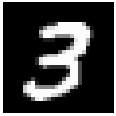

In [18]:
im3 = x_imgs[7]
show_image(im3);

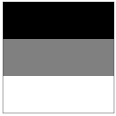

In [19]:
top_edge = tensor([[-1, -1, -1],
                   [0, 0, 0],
                   [1, 1, 1]]).float()
show_image(top_edge, noframe=False);

In [21]:
import pandas as pd

df = pd.DataFrame(im3)
df.style.format(precision=2).set_properties(**{'font_size': '7pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03,0.00,0.00,0.00,0.00,0.00


In [23]:
(im3[3:6, 14:17] * top_edge).sum()

tensor(2.9727)

In [24]:
(im3[7:10, 14:17] * top_edge).sum()

tensor(-2.9570)

In [25]:
def apply_kernel(row, col, kernel):
    return (im3[row-1:row+2, col-1:col+2] * kernel).sum()

In [26]:
apply_kernel(4, 15, top_edge)

tensor(2.9727)

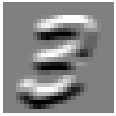

In [27]:
rng = range(1, 27)
top_edge3 = tensor([[apply_kernel(i, j, top_edge) for j in rng] for i in rng])
show_image(top_edge3);

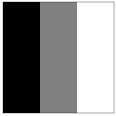

In [29]:
left_edge = tensor([[-1, 0, 1],
                   [-1, 0, 1],
                   [-1, 0, 1]]).float()
show_image(left_edge, noframe=False);

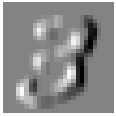

In [30]:
left_edge3 = tensor([[apply_kernel(i, j, left_edge) for j in rng] for i in rng])
show_image(left_edge3);

## Convolutions in PyTorch

In [31]:
import torch.nn.functional as F
import torch

In [32]:
inp = im3[None, None, :, :].float()
inp_unf = F.unfold(inp, (3, 3))[0]
inp_unf.shape

torch.Size([9, 676])

- `unfold` imagines a tensor as a long tensor with repeated columns/rows of values 'folded' on top of each other, which then is 'unfolded'


In [38]:
p = torch.randn(2, 5, 3, 4)
F.unfold(p, (2, 2)).shape

torch.Size([2, 20, 6])

In [39]:
w = left_edge.view(-1)
w.shape

torch.Size([9])

In [40]:
out_unf = w @ inp_unf
out_unf.shape

torch.Size([676])

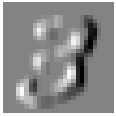

In [41]:
out = out_unf.view(26, 26)
show_image(out);

In [42]:
%timeit -n 1 tensor([[apply_kernel(i, j, left_edge) for j in rng] for i in rng]);

10.2 ms ± 3.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
%timeit -n 100 (w @ F.unfold(inp, (3, 3))[0]).view(26, 26);

68.4 µs ± 28.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
%timeit -n 100 F.conv2d(inp, left_edge[None, None])

The slowest run took 5.54 times longer than the fastest. This could mean that an intermediate result is being cached.
26.3 µs ± 23.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


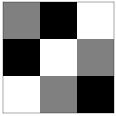

In [45]:
diag1_edge = tensor([[0, -1, 1],
                     [-1, 1, 0],
                     [1, 0, -1]]).float()
show_image(diag1_edge, noframe=False);

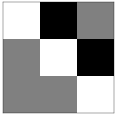

In [46]:
diag2_edge = tensor([[1, -1, 0],
                     [0, 1, -1],
                     [0, 0, 1]]).float()
show_image(diag2_edge, noframe=False);

In [47]:
xb = x_imgs[:16][:, None]
xb.shape

torch.Size([16, 1, 28, 28])

In [49]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])[:, None]
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [50]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([16, 4, 26, 26])

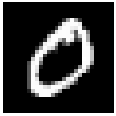

In [51]:
img0 = xb[1, 0]
show_image(img0);

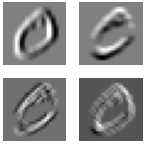

In [52]:
show_images([batch_features[1, i] for i in range(4)])

## Creating a CNN

In [53]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

In [54]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [55]:
broken_cnn = nn.Sequential(
    nn.Conv2d(1, 30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30, 10, kernel_size=3, padding=1)
)

In [56]:
broken_cnn(xb).shape

torch.Size([16, 10, 28, 28])

In [57]:
#| export
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act:
        res = nn.Sequential(res, nn.ReLU())
    return res

In [58]:
simple_cnn = nn.Sequential(
    conv(1, 4),                 # 14x14
    conv(4, 8),                 # 7x7
    conv(8, 16),                # 4x4
    conv(16, 16),               # 2x2
    conv(16, 10, act=False),    # 1x1
    nn.Flatten()
)

In [59]:
simple_cnn(xb).shape

torch.Size([16, 10])

In [60]:
x_imgs = x_train.view(-1, 1, 28, 28)
xv_imgs = x_valid.view(-1, 1, 28, 28)
train_ds, valid_ds = Dataset(x_imgs, y_train), Dataset(xv_imgs, y_valid)

In [65]:
#| export
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k, v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def collate_device(b): return to_device(default_collate(b))

In [66]:
from torch import optim

bs = 256
lr = 0.4
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs, collate_fn=collate_device)
opt = optim.SGD(simple_cnn.parameters(), lr=lr)

In [67]:
loss, acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 0.33882025413513184 0.8981000002861023
1 0.5687522699356079 0.8220000004768372
2 0.13053474612236024 0.9617999995231629
3 0.10712715346813202 0.969799999332428
4 0.16189455966949462 0.9541000006675721


In [68]:
opt = optim.SGD(simple_cnn.parameters(), lr=lr//4)
loss, acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 0.16189455966949462 0.9541000006675721
1 0.16189455966949462 0.9541000006675721
2 0.16189455966949462 0.9541000006675721
3 0.16189455966949462 0.9541000006675721
4 0.16189455966949462 0.9541000006675721


In [1]:
import nbdev
nbdev.nbdev_export()